<a href="https://colab.research.google.com/github/beinghorizontal/Quantext/blob/main/lstm_ohlc_denoised2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install yfinance
!pip install pandas_ta
!pip install torch
!pip install keras==3.0.0
!pip install livelossplot


Set Torch as backend

In [2]:
import os
import torch
os.environ["KERAS_BACKEND"] = "torch"

# Import essential libraries

In [3]:
import yfinance as yf
import datetime
import keras
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data
# from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

# Download the historical data from Yahoo finance for 15 years data, replace  'days=15' to change the years accordingly

In [4]:
ticker_symbol = "RELIANCE.NS"
start_date = datetime.datetime.now() - datetime.timedelta(days=15 * 365)
end_date = datetime.datetime.now()

df1 = yf.download(ticker_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [5]:
df = df1.copy()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# To experiment with various features keep original copy safe so you don't need to download the file from yahoo server everytime you want to change the features.

# Alternate method to download historical data You need Alpha Vantage free API key. Store that key in the text folder and replace the path. For this script I have Used  the Yahoo finance data the only difference will be the column name which will be capitalized Or in small letters

In [ ]:
#!pip install pandas-dataloader
#from pandas_datareader import data
# Download stock market data (e.g., Apple Inc.)
# with open('G:/anaconda/Scripts/data/alpha_vantage/key.txt', 'r') as f:
#     key = f.read()
# symbol = 'AAPL'  # Ticker symbol for Apple Inc.
# df = data.DataReader(symbol, "av-daily", start=datetime(2017, 2, 9),
#                     end=datetime(2024, 2, 26),
#                     api_key=key)

# We will try to normalize the values without calculating the returns. It just for the demonstration to see how it will be difficult for the LSTM model to learn effectively

# Let's plot unscaled  data 1st

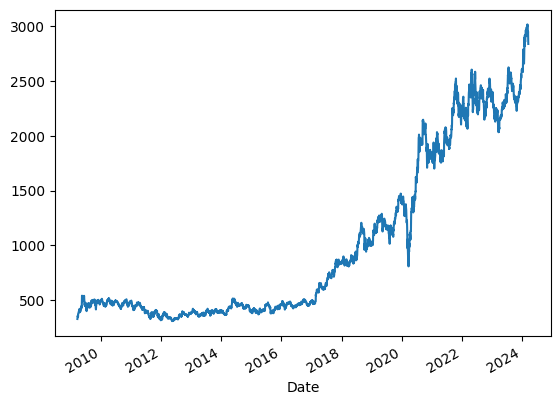

In [7]:
df['Close'].plot()
plt.show()

# Now we will normalize it without calculating the returns and plot the normalized closed value.This is the most frequent error I have seen traders do as you can see even after transforming the data only the scale will be different but you are not essentially removing any underlying trend.Model is still highly sensitive to the price itself so imagine if the price 0.2 in the skilled format has never come what is the point of the model to train on that kind of data

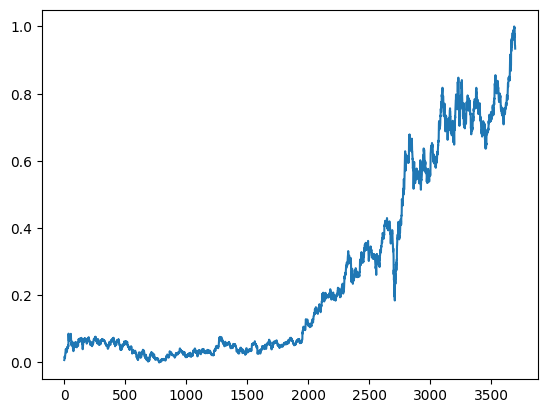

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_test = df.copy()
scaled_data = scaler.fit_transform(df_test[['Open', 'High', 'Low', 'Close','Volume']])
plt.plot(scaled_data[:, 3])

# Create Various columns with indicators based on pandas_ta  library, binary output method that is less noise but less opportunities to learn the pattern due to loss of information

In [ ]:
# df['sma_small_delta'] = np.where(df.ta.sma(length=5) > df.ta.sma(length=10),1,0)
# df['wma_small_delta'] = np.where(df.ta.wma(length=10) > df.ta.wma(length=20),1,0)
# df['sma_long_delta'] = np.where(df.ta.sma(length=20) > df.ta.sma(length=50),1,0)
# df['rsi_delta'] = np.where(df.ta.rsi(length=7) > df.ta.rsi(length=14),1,0)
# df['vwma_small_delta'] = np.where(df.ta.vwma(length=5) > df.ta.vwma(length=10),1,0)
# df['vwma_long_delta'] = np.where(df.ta.vwma(length=10) > df.ta.vwma(length=20),1,0)
#df['percent_return_20'] = df.ta.percent_return(length=20)
# df_vortex = df.ta.vortex(length=14)  # Vortex indicator has two oscillators positive and negative. We calculate the delta
# df_vortex['plus_delta'] = np.where(df_vortex['VTXP_14'] > df_vortex['VTXM_14'],1,0)
# df['vortex_plus_delta'] = df_vortex['plus_delta']


# Create columns best on pandas_ta library, non binary method that is more noise but more opportunities to learn the pattern

In [9]:
import pandas_ta as ta
df['sma_small_delta'] = (df.ta.sma(length=5) - df.ta.sma(length=10))/df.ta.sma(length=10)
df['wma_small_delta'] = (df.ta.wma(length=10) - df.ta.wma(length=20))/df.ta.wma(length=20)
df['sma_long_delta'] = (df.ta.sma(length=20) - df.ta.sma(length=50))/df.ta.sma(length=50)
df['rsi_delta'] = (df.ta.rsi(length=7) - df.ta.rsi(length=14)) / df.ta.rsi(length=14)
df['vwma_small_delta'] = (df.ta.vwma(length=5) - df.ta.vwma(length=10))/df.ta.vwma(length=10) # Volume weighted moving average
df['vwma_long_delta'] = (df.ta.vwma(length=10) - df.ta.vwma(length=20))/df.ta.vwma(length=20)
df['percent_return_20'] = df.ta.percent_return(length=20)
# df_vortex = df.ta.vortex(length=14)  # Vortex indicator has two oscillators positive and negative. We calculate the delta
# df_vortex['plus_delta'] = (df_vortex['VTXP_14'] - df_vortex['VTXM_14'])/df_vortex['VTXM_14']
# df['vortex_plus_delta'] = df_vortex['plus_delta']
df['atr'] = df.ta.atr()/df['Close']
df['roc5'] = df.ta.roc(length=5)
df['roc'] = df.ta.roc()
df= df.dropna()


# plot any one indicator to confirm stationary properties

<Axes: xlabel='Date'>

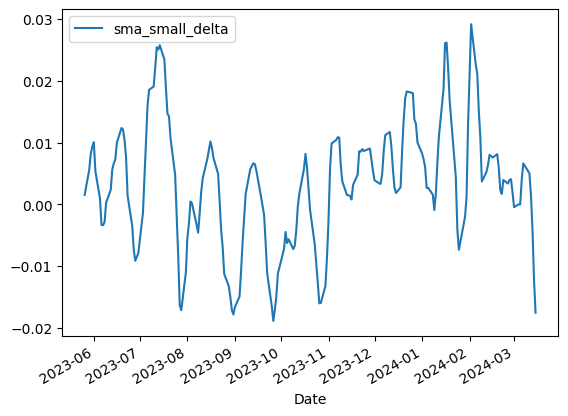

In [10]:
df[['sma_small_delta']].tail(200).plot() # Zoom in view to see if there is randomness or some cyclical pattern


In [ ]:
#df.ta.percent_return(length=20)

In [ ]:
#df.ta.indicators()

In [ ]:
#help(ta.vwma)


In [ ]:
# df.ta.roc().tail(200).plot()
# plt.show()

In [11]:
df = df.dropna()

# check what dataframe looks like because we are going to normalize the remaining data later
# Most of the values have positive and negative numbers. So we will use minmax scaler range is equal to -1, 1

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [13]:
print(df.columns.to_list())

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'sma_small_delta', 'wma_small_delta', 'sma_long_delta', 'rsi_delta', 'vwma_small_delta', 'vwma_long_delta', 'percent_return_20', 'atr', 'roc5', 'roc']


In [14]:
columns_to_norm = ['sma_small_delta', 'wma_small_delta', 'sma_long_delta', 'rsi_delta', 'vwma_small_delta', 'vwma_long_delta', 'percent_return_20', 'atr', 'roc5', 'roc']
#columns_to_norm = ['All_Candle_Patterns']

for col in columns_to_norm:
    df[[col]] = scaler.fit_transform(df[[col]])


# Create 5 day sma for target

In [15]:
df['5sma_lag'] = df['Close'].rolling(5).mean()
df['target_close'] = df['Close'].shift(-1)
# create binary target
df['target'] = (df['target_close'] > df['5sma_lag']).astype(int)

df = df.dropna()


# create binary target

In [16]:
df = df.dropna()
print(df[['Close','target_close','5sma_lag','target']].head(10))

                 Close  target_close    5sma_lag  target
Date                                                    
2009-06-11  526.484192    539.936340  516.705414       1
2009-06-12  539.936340    498.037018  523.533197       0
2009-06-15  498.037018    489.933746  522.838300       0
2009-06-16  489.933746    468.904114  516.950000       0
2009-06-17  468.904114    462.892365  504.659082       0
2009-06-18  462.892365    466.652557  491.940717       0
2009-06-19  466.652557    446.308655  477.283960       0
2009-06-22  446.308655    460.663666  466.938287       0
2009-06-23  460.663666    457.703522  461.084271       0
2009-06-24  457.703522    447.588715  458.844153       0


In [32]:
df[['Close','target_close','5sma_lag']].plot()

KeyError: "None of [Index(['Close', 'target_close', '5sma_lag'], dtype='object')] are in the [columns]"

# drop unwanted columns

In [17]:
df = df.drop(['Open', 'High','Low', 'Close', 'Adj Close', 'Volume','5sma_lag','target_close','atr'],axis=1)

In [18]:
df = df.dropna()

# Create target and features

In [19]:
features = df.drop('target', axis=1).values
target = df['target'].values

In [20]:
def create_sequences(features, target, sequence_length):
    X = []
    y = []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(target[i+(sequence_length-1)])
    return np.array(X), np.array(y)

sequence_length = 10
X, y = create_sequences(features, target, sequence_length)

# split X and Y into training and validation sets

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4,shuffle=False)


In [22]:
print("Training shape:", X_train.shape)
print("Validation shape:", X_val.shape)

Training shape: (2180, 10, 9)
Validation shape: (1454, 10, 9)


In [23]:
num_features = X_train.shape[2]
print(num_features)

9


In [24]:
from keras.optimizers import Adam
from keras.regularizers import l1_l2,l1,l2
from keras.layers import LeakyReLU
# inputs = Input(shape=(sequence_length, X_train.sha))  # Replace with appropriate values


# Build the LSTM model
model = Sequential()
# model.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, num_features), activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
#model.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, num_features), activation='relu', kernel_regularizer=l1(0.001)))
# model.add(LSTM(152, return_sequences=True, activation='relu'))  # Add an extra LSTM layer
#model.add(Dropout(0.5))
#model.add(LSTM(92, return_sequences=True, activation='relu'))  # Add an extra LSTM layer
#model.add(Dropout(0.4))
model.add(LSTM(32, return_sequences=True, activation='relu',input_shape=(sequence_length, num_features) ))  # Add an extra LSTM layer
# # model.add(Dropout(0.4))
# model.add(LSTM(32, return_sequences=True, activation='relu'))  # Add an extra LSTM layer
# # model.add(Dropout(0.4))
# model.add(LSTM(8, return_sequences=True, activation='tanh'))  # Add an extra LSTM layer
# # # model.add(Dropout(0.4))
model.add(LSTM(8))  # Add an extra LSTM layer
# model.add(Dense(1, activation='sigmoid',  kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.001) # default is 0.001
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
early_stopping = EarlyStopping(monitor='val_loss',    # Monitor the val loss
                               patience=150,           # Num epochs; if no improvement training will be stopped
                               verbose=1,
                               mode='min',            # The training will stop when the quantity monitored has stopped decreasing
                               restore_best_weights=True) # Restores model weights from the epoch with the best value of the monitored quantity.

In [27]:

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('/content/best_model.keras',   # Path where to save the model
                                   monitor='val_loss',   # Monitor the validation loss
                                   save_best_only=True,  # The latest best model according to the quantity monitored will not be overwritten
                                   mode='min',           # The training will save the model when the quantity monitored has decreased
                                   verbose=1)


In [29]:
from livelossplot import PlotLossesKeras
plot_losses = PlotLossesKeras()

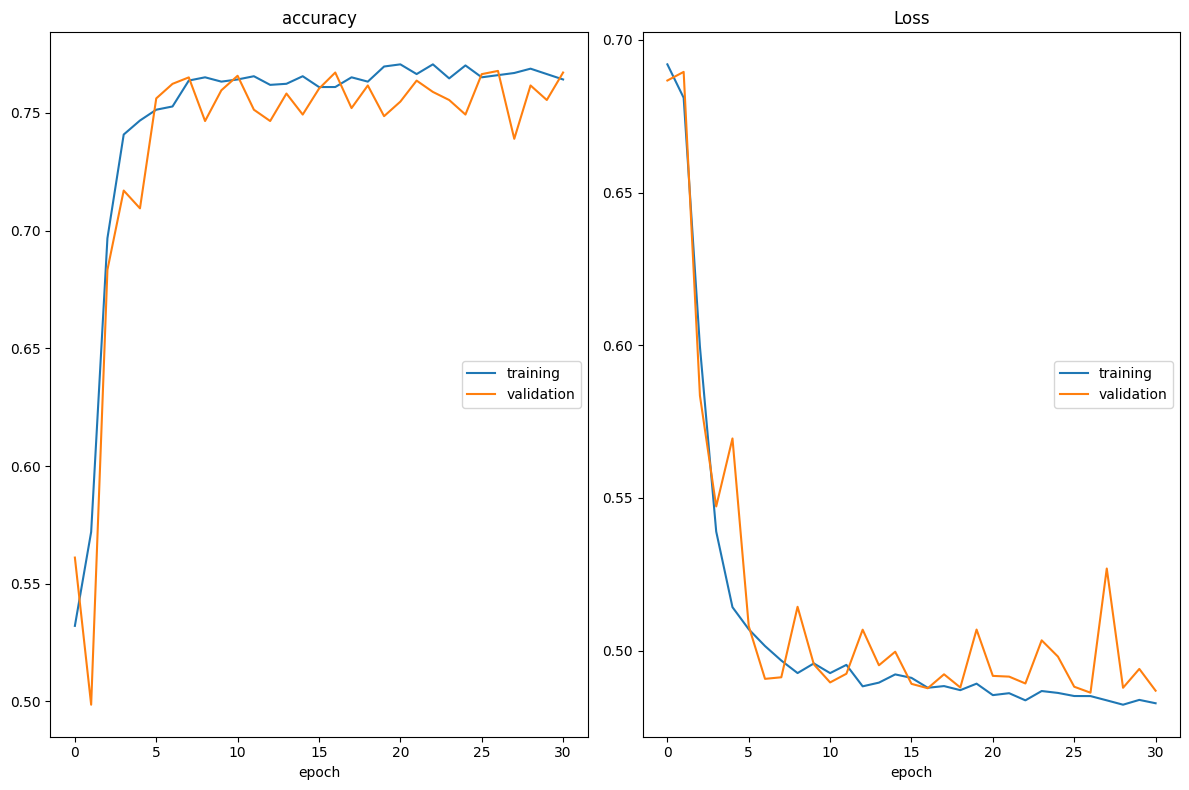

accuracy
	training         	 (min:    0.532, max:    0.771, cur:    0.764)
	validation       	 (min:    0.499, max:    0.768, cur:    0.767)
Loss
	training         	 (min:    0.482, max:    0.692, cur:    0.483)
	validation       	 (min:    0.486, max:    0.690, cur:    0.487)


KeyboardInterrupt: 

In [31]:
model.fit(X_train, y_train,
                    epochs=1000,
                    batch_size=4,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint,plot_losses],
                    verbose=False)


#plot model architecture

In [ ]:
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)
